Logistic Regression for transcriptomic prediciton 


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
data = pd.read_csv("gene_data.csv")

In [40]:

# Load your data
# Replace 'gene_expression.csv' and 'patient_annotation.csv' with actual file paths
gene_expression_df = pd.read_csv('serial_norm_gene_exp_df.csv', index_col=0)  # Gene expression data
patient_annotation_df = pd.read_csv('serial_samples_annotation.csv')          # Patient annotation data

# Step 1: Calculate the average expression for each gene and select the top 500 genes

# Step 2: Transpose gene data to have patients as rows and genes as columns
genes_transposed = gene_expression_df.T
genes_transposed.index.name = 'X'  # Rename index to match patient ID for merging

# Step 3: Merge the gene expression data with patient annotations
combined_df = patient_annotation_df.merge(genes_transposed, on='X', how='inner')
combined_df.head()
# Step 4: Prepare features (gene expressions) and target (Delirium) for modeling
X = combined_df.drop(columns=['X', 'Delirium', 'Diagnosis', 'Steroids', 'Late_del', 'Subject', 'Day'])  # Feature matrix
y = combined_df['Diagnosis']  # Target variable
X.head()
y.head()
from sklearn.feature_selection import SelectKBest, f_classif
#ANOVA F-value between label/feature for classification tasks.
select_features = SelectKBest(f_classif, k = 200).fit(X, y)

X_selected = select_features.fit_transform(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver = 'liblinear', random_state = 0, max_iter=1000, penalty = 'l2')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))





# Plot ROC Curve



Accuracy of logistic regression classifier on test set: 0.90


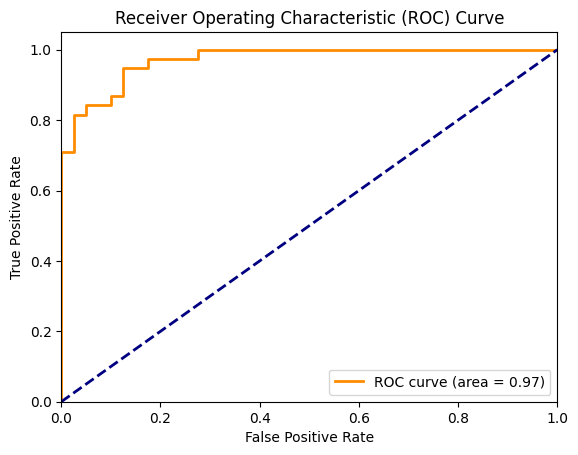

In [41]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

y_proba = logreg.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=logreg.classes_[1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [42]:
feature_importance = np.abs(logreg.coef_[0])  # Take the absolute value of coefficients
feature_names = X.columns

# Sort features by importance
important_features = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)

# Display the top features
top_features = important_features[:10]  # Top 10 most important features
print("Top 10 important features:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")


Top 10 important features:
DBF4: 1.2347653520272792
ETV7: 0.9839633062137184
PHTF2: 0.8584249697680418
PHF7: 0.73546334925559
UQCRC1: 0.7215187634264258
ST3GAL1: 0.6616744982220834
BAZ1B: 0.6473891689633184
CD4: 0.6407655957892059
SPRTN: 0.640368687646907
NFIX: 0.6311929830464564


In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load your data (replace with your actual dataset paths)
gene_expression_df = pd.read_csv('serial_norm_gene_exp_df.csv', index_col=0)
patient_annotation_df = pd.read_csv('serial_samples_annotation.csv')

# Preprocessing similar to before
gene_expression_df['average_expression'] = gene_expression_df.mean(axis=1)
top_500_genes = gene_expression_df.nlargest(500, 'average_expression').drop(columns=['average_expression'])
top_500_genes_transposed = top_500_genes.T
top_500_genes_transposed.index.name = 'X'

combined_df = patient_annotation_df.merge(top_500_genes_transposed, on='X', how='inner')
X = combined_df.drop(columns=['X', 'Delirium', 'Diagnosis', 'Steroids', 'Late_del', 'Subject', 'Day'])
y = combined_df['Diagnosis']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features to make coefficient magnitudes comparable
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train logistic regression model
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train, y_train)

# Get coefficients and feature importance
feature_importance = np.abs(log_reg.coef_[0])  # Take the absolute value of coefficients
feature_names = X.columns

# Sort features by importance
important_features = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)

# Display the top features
top_features = important_features[:10]  # Top 10 most important features
print("Top 10 important features:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")


Top 10 important features:
SNN: 1.124437390915885
LSP1: 1.1064459644024347
IGHA1: 0.7617647879589575
ATP2A3: 0.6896753985627476
CAPG: 0.643110173286472
SLC11A1: 0.6011352071667785
RAC1: 0.5994710825711427
GRB2: 0.5808826592271551
ND1: 0.5412377828861468
THEMIS2: 0.5402919562754351


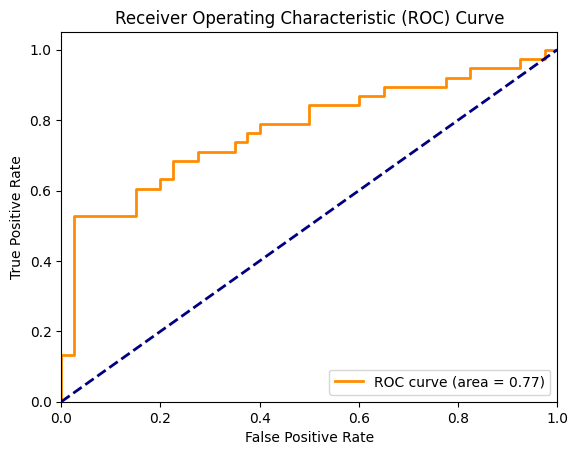

In [46]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

y_proba = log_reg.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=log_reg.classes_[1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()